In [10]:
import numpy as np
import pandas as pd
import os
import random,math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import display_methods
import load_raw

In [36]:
lr = load_raw.load_dta()

In [37]:
print(lr.columns.values)
lr.head()

['channel 1' 'channel 2' 'channel 3' 'channel 4' 'timestamp(ms)'
 'keypressed']


,channel 1,channel 2,channel 3,channel 4,timestamp(ms),keypressed
0,-19410.30,-18125.56,-28213.76,25508.35,1.581898e+12,NaN
1,-19422.86,-18301.96,-28234.25,25617.09,1.581898e+12,NaN
2,-19389.04,-17962.26,-28220.28,25626.86,1.581898e+12,NaN
3,-19374.13,-17722.12,-28198.13,25529.27,1.581898e+12,NaN
4,-19410.57,-18055.60,-28208.26,25486.98,1.581898e+12,NaN


following [this tutorial](https://kevinsprojects.wordpress.com/2014/12/13/short-time-fourier-transform-using-python-and-numpy/)

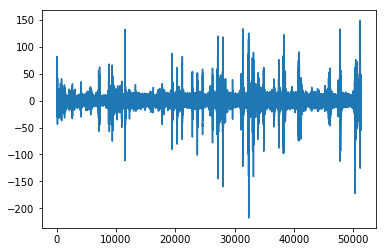

In [47]:
data.shape
plt.plot(data[100:])

In [44]:
data = np.asarray(lr['channel 2'])
data = display_methods.filter_signal(data)[100:]
fs = 250 # sampling frequency of the data, dunno exactly what it should be

overlap_fac = .1
hop_size = 15
fft_size = 20

notch filter removing:57.0-63.0Hz


In [39]:
hop_size = np.int32(np.floor(fft_size * (1-overlap_fac)))
pad_end_size = fft_size # the last segment can overlap but no more than one window size
total_segments = np.int32(np.ceil(len(data) / np.float32(hop_size)))

window = np.hanning(fft_size) # half cosine window
inner_pad = np.zeros(fft_size) # the zeros which will be used to double each segment size

proc = np.concatenate((data, np.zeros(pad_end_size)))
result = np.empty((total_segments, fft_size),dtype=np.float32)

for i in range(total_segments):
    current_hop = hop_size * i
    segment = proc[current_hop:current_hop+fft_size]
    windowed = segment * window
    padded = np.append(windowed, inner_pad)
    spectrum = np.fft.fft(padded) / fft_size
    autopower = np.abs(spectrum * np.conj(spectrum))
    result[i,:] = autopower[:fft_size]
    
result = 20*np.log10(result)
result = np.clip(result, -40, 200)



/home/steve/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10


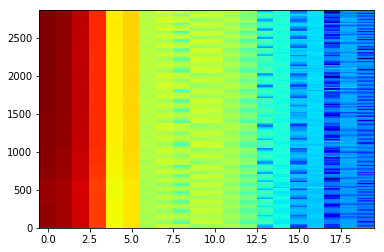

In [40]:
img = plt.imshow(result, origin='lower', cmap='jet',interpolation='nearest',aspect='auto')
plt.show()

### adapting marley's spec code
methods

In [162]:
def get_spectral_content(ch, fs_Hz, shift=.1):
    NFFT = fs_Hz*2
    overlap = NFFT - int(shift * fs_Hz)
    spec_PSDperHz, spec_freqs, spec_t = mlab.specgram(np.squeeze(ch),
                                                     NFFT=NFFT,
                                                     window=mlab.window_hanning,
                                                     Fs=fs_Hz,
                                                     noverlap=overlap
                                                     ) # returns PSD power per Hz
    # convert the units of the spectral data
    spec_PSDperBin = spec_PSDperHz * fs_Hz / float(NFFT)
    return spec_t, spec_freqs, spec_PSDperBin # dB re: 1 uV

def plot_specgram(spec_freqs, spec_PSDperBin, title, shift,no_chan, i=1,cmap='terrain'):
    f_lim_Hz = [0, 30]   # frequency limits for plotting
    #plt.figure(figsize=(10,5))# assume figure obj already initialised
    spec_t = [idx*.1 for idx in range(len(spec_PSDperBin[0]))]
    plt.subplot(no_chan,1,i)
    plt.title(title)
    plt.pcolor(spec_t, spec_freqs, 10*np.log10(spec_PSDperBin),cmap=cmap)  # dB re: 1 uV
    plt.clim([-25,26])
    plt.xlim(spec_t[0], spec_t[-1]+1)
    plt.ylim(f_lim_Hz)
    plt.xlabel('Time (sec)')
    plt.ylabel('Frequency (Hz)')
    plt.subplots_adjust(hspace=.5)

plotting

In [142]:
channel = [1,2,3,4]

lr = load_raw.load_dta(channel=channel+[13])
data = np.asarray(lr['channel 1'])
data = display_methods.filter_signal(data)[200:]

# trim the data (taken from display methods)
keypressed = lr['keypressed']
start_idx = keypressed.first_valid_index()
stop_idx = keypressed.last_valid_index()
lr_trimmed = lr.truncate(before=start_idx-500,after=stop_idx+500)
only_keypressed = lr_trimmed[lr_trimmed['keypressed'].notna()]

notch filter removing:57.0-63.0Hz


In [143]:
lr.columns.values

array(['channel 1', 'channel 2', 'channel 3', 'channel 4',
       'timestamp(ms)', 'keypressed'], dtype=object)

In [144]:
only_keypressed.head()

,channel 1,channel 2,channel 3,channel 4,timestamp(ms),keypressed
11059,-18710.35,-17404.14,-26230.69,26774.80,1.581898e+12,k
11543,-18841.54,-17908.26,-25679.61,26784.34,1.581898e+12,;
17795,-18628.32,-19684.76,-24712.38,27221.54,1.581898e+12,l
19479,-19248.43,-21071.46,-24127.46,27335.76,1.581898e+12,l
20320,-19121.09,-20673.71,-24109.35,27424.99,1.581898e+12,k


In [145]:
# markings = [only_keypressed.iloc[i].name for i in range(len(only_keypressed))]
# labels = only_keypressed['keypressed']
# # for now trim them only take first 5
# markings = markings[:5]
# labels = labels[:5]

In [146]:
# # just plot channel 1
# idx=0
# ch = np.asarray(lr['channel 1'])
# t, spec_freqs, spec_PSDperBin = get_spectral_content(ch[start_idx:start_idx + 10000], 250)
# fig=plt.figure(figsize=(10,10), dpi=80, facecolor='w', edgecolor='k')
# plot_specgram(spec_freqs, spec_PSDperBin, 'channel = {}'.format(idx + 1), 0)
# for mark, label in zip(markings, labels):
#     plt.text((mark - start_idx)/250,10,label,color='white',fontsize=15)

notch filter removing:57.0-63.0Hz
notch filter removing:57.0-63.0Hz
notch filter removing:57.0-63.0Hz
notch filter removing:57.0-63.0Hz


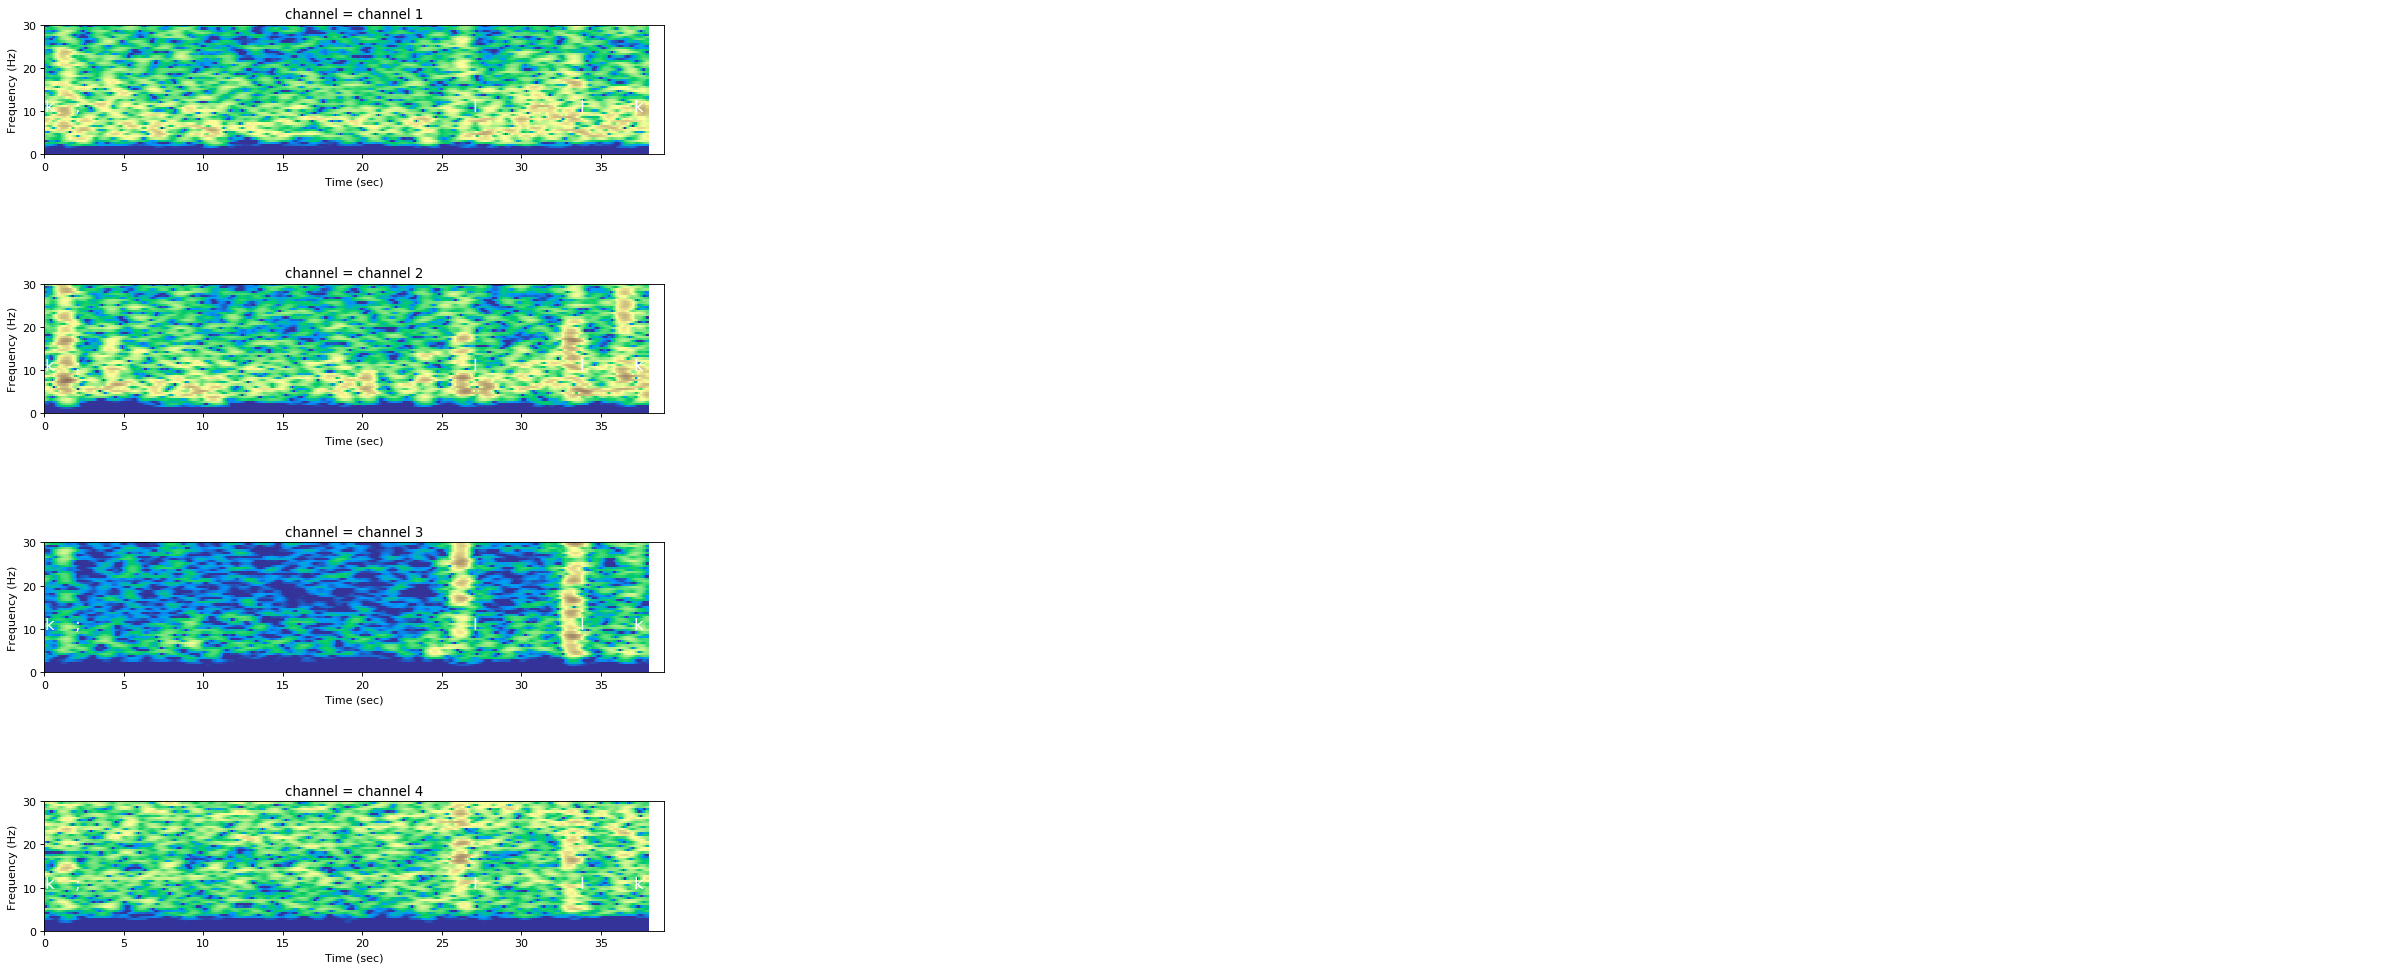

In [161]:
# plot multiple channels
markings = np.asarray([only_keypressed.iloc[i].name for i in range(len(only_keypressed))])
labels = np.asarray(only_keypressed['keypressed'])
markings_labels = np.asarray([markings,labels]).T

ch_names = [i for i in lr.columns.values if i not in ('timestamp(ms)','keypressed')]
eeg = np.asarray([lr[i] for i in ch_names])
# filter the signal - important
for i in range(len(eeg)):
    eeg[i] = display_methods.filter_signal(eeg[i])

fig = plt.figure(figsize=(10,15),dpi=80, facecolor='w',edgecolor='k')
for idx, ch in enumerate(eeg):
    stop_plot_idx = start_idx + 10000
    t, spec_freqs, spec_PSDperBin = get_spectral_content(ch[start_idx:stop_plot_idx], 250)
#     fig=plt.figure(figsize=(10,10), dpi=80, facecolor='w', edgecolor='k')
    plot_specgram(spec_freqs, spec_PSDperBin, 'channel = {}'.format(ch_names[idx]), 
                  shift=0,no_chan=len(ch_names),i=idx+1,
                  cmap='terrain')
    # trim the markings and labels to only those that are within the time-frame
    markings_trimmed = [(m,l) for m,l in markings_labels if m<stop_plot_idx and m>start_idx]
    for mark, label in markings_labels:
        plt.text((mark-start_idx)/250,10,label,color='white',fontsize=15)
# plt.show()
plt.savefig('spec1.png')

my favourite colormaps:
'terrain'
'ocean'
'rainbow'
'gist_ncar'
'hsv'
#### the winner is 'terrain'

In [1]:
from spec_util import *

notch filter removing:57.0-63.0Hz


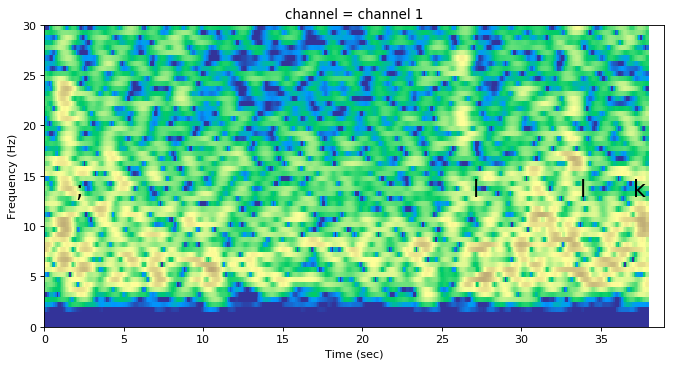

In [2]:
disp1(channel=[1],save_as='channel1_spec.png')